# ETL REVIEW

### IMPORTACION LIBRERIAS

In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pylab as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import os
import json
import ast
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime

### Cragamos los archivos para filtrar solo las reseñas que necesitamos (las de los restaurantes, cafe, bares...)

In [2]:
# Carga los archivos parquet
df_business = pd.read_parquet(r"../../data/raw/yelp/bussines_processed.parquet")
df_review = pd.read_parquet(r"../../data/raw/yelp/review.parquet")

# Realiza el merge para obtener solo las reseñas con el mismo business_id
# Solo se seleccionan los registros de df_review que tienen un business_id en df_business
df_reviews_filtered = df_review[df_review['business_id'].isin(df_business['business_id'])]

# Muestra el DataFrame resultante
print(df_reviews_filtered)

                      review_id                 user_id  \
98       PPgbLBvi34A6m7bKJfTwhw  3TL6HZ1JrKcNTvGDWKlrow   
303      Is_4BTKGJTHxLGKRxLD_DQ  V8P2-U2IINNHzALqjaN3gQ   
565      B64w3FRqtalYlf2JQyqSEw  RDKpadmqI2CpSvRUy_sorQ   
706      alP0N_bFRdeV1oVeKzvlZQ  tAVuWx4pgvXn5WrRWUljkA   
769      NgMX1BwJd5meAWEqXVC_OQ  e9pCi-A2zVniFyNqVzBzpA   
...                         ...                     ...   
6989864  mDOcg6OBQDtN90QEFS0Fsw  wWiuYPazll9cvG0baz1jWg   
6989874  fO9yXdwB7ooRDLEc4fuyrw  sb3t5fHGm0Zxx6oJtlPCgQ   
6989881  lr6pc98LEmrVYxI8kA53Lg  ZvVGfHQ_5otSmkLOAPsaJQ   
6989968  0w8gq_iAT27KE7S8bd7eBw  1pR5fCGVpPydBbu94KGi_Q   
6989991  GFRlTYmxZpooOnVk6QviRw  Hnkw_-DPYVMnG2d1G5PbnQ   

                    business_id  stars  useful  funny  cool  \
98       GyC36Pn0Q1-qHnqXys6yFg    1.0       0      0     0   
303      GyC36Pn0Q1-qHnqXys6yFg    3.0       0      0     0   
565      I1h0GRYp86eX-XqwVXsSGA    5.0       0      0     0   
706      SwBhaxfQPbyhsi0QHUAN0A    4.0 

In [3]:
df_reviews_filtered = pd.json_normalize(df_reviews_filtered.to_dict(orient='records'))

print(df_reviews_filtered.head())

                review_id                 user_id             business_id  \
0  PPgbLBvi34A6m7bKJfTwhw  3TL6HZ1JrKcNTvGDWKlrow  GyC36Pn0Q1-qHnqXys6yFg   
1  Is_4BTKGJTHxLGKRxLD_DQ  V8P2-U2IINNHzALqjaN3gQ  GyC36Pn0Q1-qHnqXys6yFg   
2  B64w3FRqtalYlf2JQyqSEw  RDKpadmqI2CpSvRUy_sorQ  I1h0GRYp86eX-XqwVXsSGA   
3  alP0N_bFRdeV1oVeKzvlZQ  tAVuWx4pgvXn5WrRWUljkA  SwBhaxfQPbyhsi0QHUAN0A   
4  NgMX1BwJd5meAWEqXVC_OQ  e9pCi-A2zVniFyNqVzBzpA  _KSRzh-ZxwKB3YcRlZQsGA   

   stars  useful  funny  cool  \
0    1.0       0      0     0   
1    3.0       0      0     0   
2    5.0       0      0     0   
3    4.0       1      0     0   
4    5.0       0      0     0   

                                                text                 date  
0  Service and management terrible... After messi...  2013-12-07 13:17:13  
1  It's my first time here and the service is slo...  2016-01-30 05:24:09  
2  THE BEST place to go for gyros! The quality of...  2015-02-16 21:55:00  
3  I've only been to their casino 

### NULOS

In [4]:
df_reviews_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63387 entries, 0 to 63386
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    63387 non-null  object 
 1   user_id      63387 non-null  object 
 2   business_id  63387 non-null  object 
 3   stars        63387 non-null  float64
 4   useful       63387 non-null  int64  
 5   funny        63387 non-null  int64  
 6   cool         63387 non-null  int64  
 7   text         63387 non-null  object 
 8   date         63387 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.4+ MB


In [5]:
df_reviews_filtered.isnull().sum() # Revisamos si hay valores nulos.

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

### DUPLICADOS

In [6]:
df_reviews_filtered.duplicated().sum() # Revisamos si hay valores duplicados.

np.int64(0)

### DESANIDAR COLUMNA

In [7]:
# Desanidar la columna "date"
desanidados = []  # Lista vacía para almacenar los datos desanidados.

for _, row in df_reviews_filtered.iterrows():
    review_id = row['review_id']
    user_id = row['user_id']
    business_id = row['business_id']
    stars = row['stars']
    useful = row['useful']
    funny = row['funny']
    cool = row['cool']
    text = row['text']

    for datetime_str in str(row['date']).split(', '):
      datetime_parts = datetime_str.split(' ')
      date = datetime_parts[0]
      hour = datetime_parts[1] if len(datetime_parts) > 1 else None  # Usamos None si no hay hora disponible
      desanidados.append([review_id, user_id, business_id, stars, useful, funny, cool, text, date, hour])

df_desanidado = pd.DataFrame(desanidados, columns=['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date', 'hour'])


In [8]:
df_desanidado.head(4)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,hour
0,PPgbLBvi34A6m7bKJfTwhw,3TL6HZ1JrKcNTvGDWKlrow,GyC36Pn0Q1-qHnqXys6yFg,1.0,0,0,0,Service and management terrible... After messi...,2013-12-07,13:17:13
1,Is_4BTKGJTHxLGKRxLD_DQ,V8P2-U2IINNHzALqjaN3gQ,GyC36Pn0Q1-qHnqXys6yFg,3.0,0,0,0,It's my first time here and the service is slo...,2016-01-30,05:24:09
2,B64w3FRqtalYlf2JQyqSEw,RDKpadmqI2CpSvRUy_sorQ,I1h0GRYp86eX-XqwVXsSGA,5.0,0,0,0,THE BEST place to go for gyros! The quality of...,2015-02-16,21:55:00
3,alP0N_bFRdeV1oVeKzvlZQ,tAVuWx4pgvXn5WrRWUljkA,SwBhaxfQPbyhsi0QHUAN0A,4.0,1,0,0,I've only been to their casino and I love that...,2012-10-08,19:34:31


In [9]:
df_desanidado.to_parquet(r"../../data/raw/yelp/review_processed.parquet", index= True)


# EDA REVIEW

In [10]:
len(df_desanidado['stars'].unique())

5

In [11]:
value_counts = df_desanidado["stars"].value_counts()

In [12]:
value_counts

stars
5.0    29724
4.0    14782
1.0     7196
3.0     6916
2.0     4769
Name: count, dtype: int64

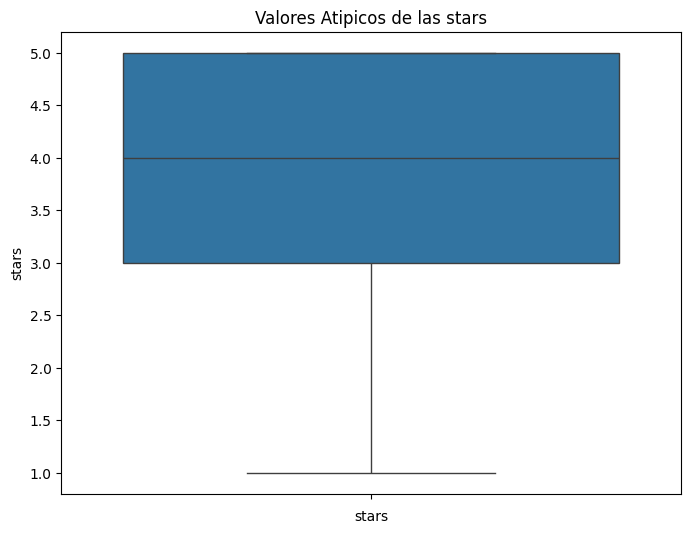

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(df_desanidado['stars'])
plt.xlabel('stars')
plt.title('Valores Atipicos de las stars')
plt.show()

              stars        useful         funny          cool
count  63387.000000  63387.000000  63387.000000  63387.000000
mean       3.868774      1.078249      0.329563      0.638270
std        1.372412      3.468566      1.791667      2.970025
min        1.000000      0.000000      0.000000      0.000000
25%        3.000000      0.000000      0.000000      0.000000
50%        4.000000      0.000000      0.000000      0.000000
75%        5.000000      1.000000      0.000000      1.000000
max        5.000000    192.000000    139.000000    183.000000


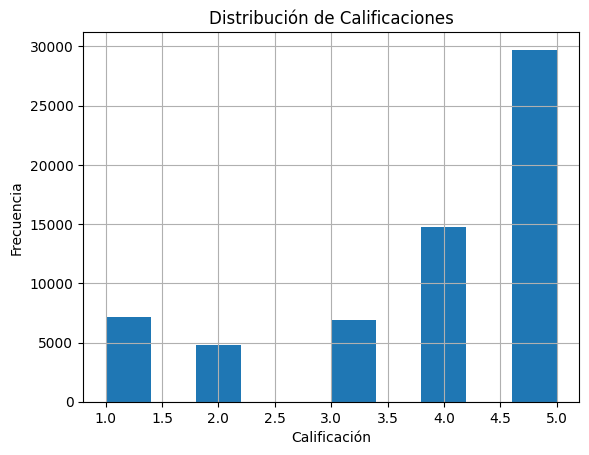

In [15]:
# Resumen estadístico
print(df_desanidado.describe())

# Histograma de calificaciones
df_desanidado['stars'].hist()
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()

### REVIEWS USEFUL

In [16]:
len(df_desanidado['useful'].unique())

75

In [17]:
value_counts = df_desanidado["useful"].value_counts()

In [18]:
value_counts

useful
0      37056
1      14010
2       5460
3       2504
4       1346
       ...  
192        1
162        1
57         1
53         1
41         1
Name: count, Length: 75, dtype: int64

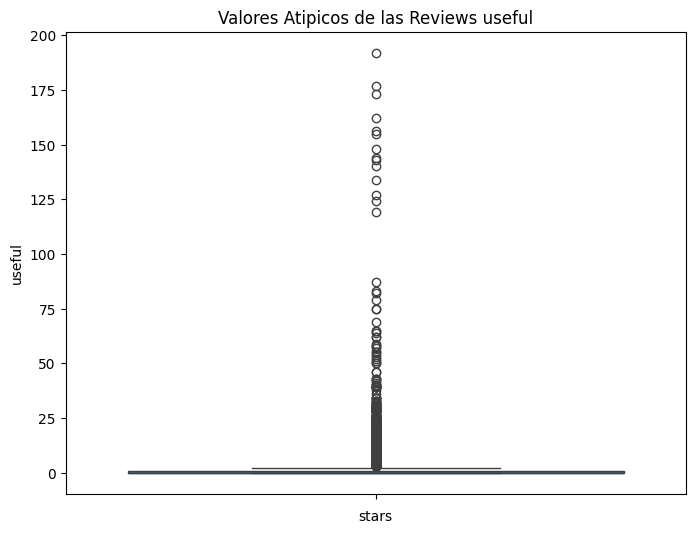

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(df_desanidado['useful'])
plt.xlabel('stars')
plt.title('Valores Atipicos de las Reviews useful')
plt.show()

### REVIEWS FUNNY

In [21]:
len(df_desanidado['funny'].unique())

48

In [22]:
value_counts = df_desanidado["funny"].value_counts()

In [23]:
value_counts

funny
0      53727
1       6104
2       1626
3        763
4        385
5        227
6        160
7         98
8         58
9         54
10        28
11        25
12        23
13        13
14        10
16         9
20         7
15         7
17         6
26         5
19         5
25         5
18         4
27         4
21         3
32         3
35         3
29         2
82         2
36         2
68         2
90         1
37         1
79         1
85         1
101        1
23         1
59         1
33         1
22         1
40         1
81         1
87         1
139        1
94         1
46         1
28         1
75         1
Name: count, dtype: int64

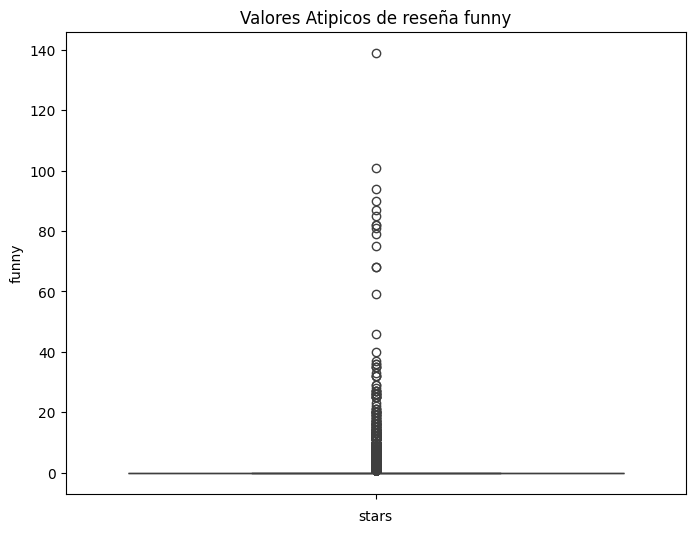

In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(df_desanidado['funny'])
plt.xlabel('stars')
plt.title('Valores Atipicos de reseña funny')
plt.show()

### REVIEWS COOL

In [25]:
len(df_desanidado['cool'].unique())

71

In [26]:
value_counts = df_desanidado["cool"].value_counts()

In [27]:
value_counts

cool
0     47122
1      9855
2      2838
3      1248
4       627
      ...  
56        1
54        1
87        1
55        1
36        1
Name: count, Length: 71, dtype: int64

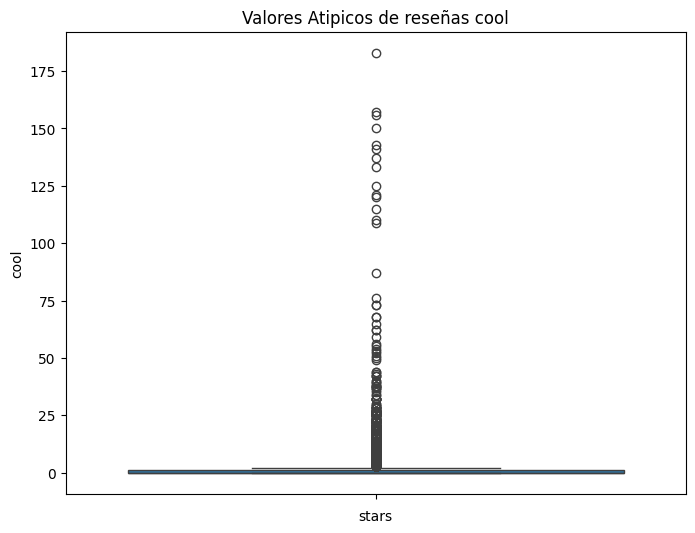

In [28]:
plt.figure(figsize=(8, 6))
sns.boxplot(df_desanidado['cool'])
plt.xlabel('stars')
plt.title('Valores Atipicos de reseñas cool')
plt.show()

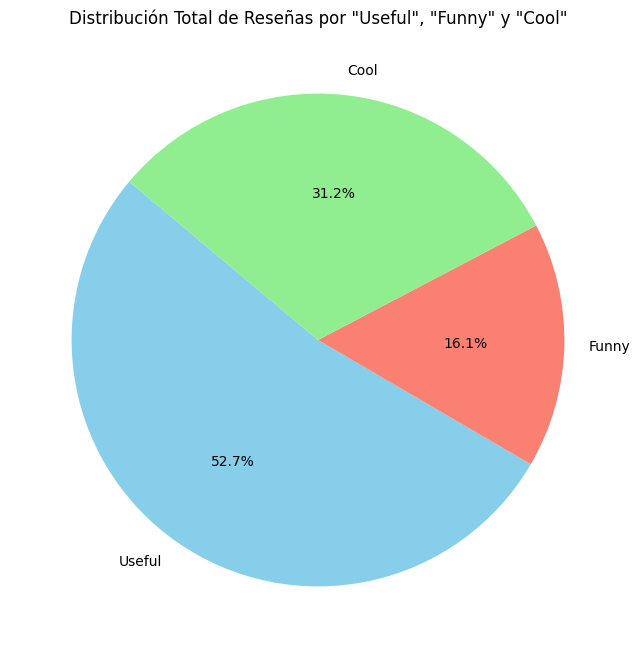

In [29]:

# Sumar los valores totales de cada columna
total_useful = df_desanidado['useful'].sum()
total_funny = df_desanidado['funny'].sum()
total_cool = df_desanidado['cool'].sum()

# Lista de valores y etiquetas para el gráfico de torta
valores = [total_useful, total_funny, total_cool]
etiquetas = ['Useful', 'Funny', 'Cool']
colores = ['skyblue', 'salmon', 'lightgreen']

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(valores, labels=etiquetas, colors=colores, autopct='%1.1f%%', startangle=140)
plt.title('Distribución Total de Reseñas por "Useful", "Funny" y "Cool"')
plt.show()


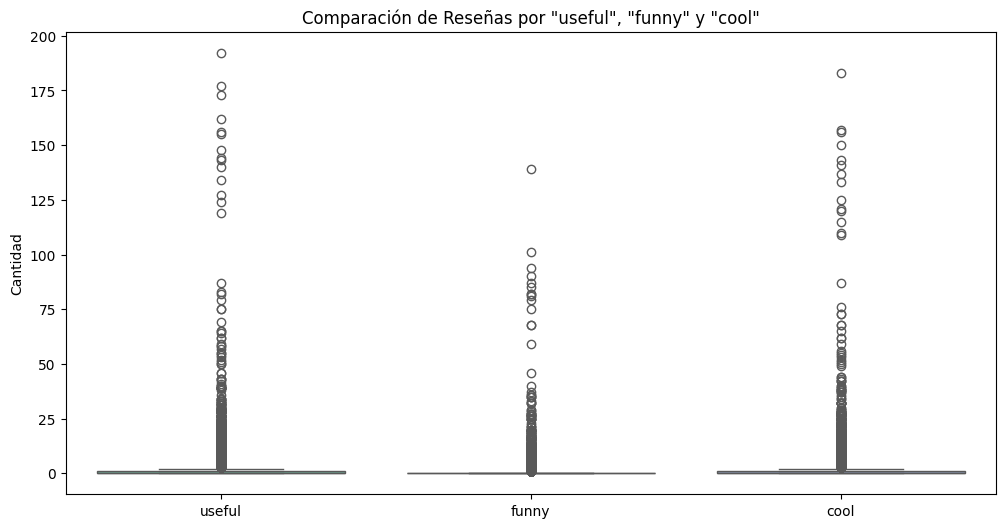

In [31]:
# Boxplot comparativo
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_desanidado[['useful', 'funny', 'cool']], palette='Set2')
plt.title('Comparación de Reseñas por "useful", "funny" y "cool"')
plt.ylabel('Cantidad')
plt.show()

### DISTRIBUCION DATE

In [32]:
len(df_desanidado['date'].unique())

4712

In [33]:
value_counts = df_desanidado["date"].value_counts()

In [34]:
value_counts

date
2019-08-04    48
2018-06-24    46
2019-07-13    46
2018-06-02    44
2018-03-10    44
              ..
2008-11-10     1
2009-09-27     1
2010-04-20     1
2010-06-27     1
2010-06-18     1
Name: count, Length: 4712, dtype: int64

### TENDENCIAS TEMPORALES

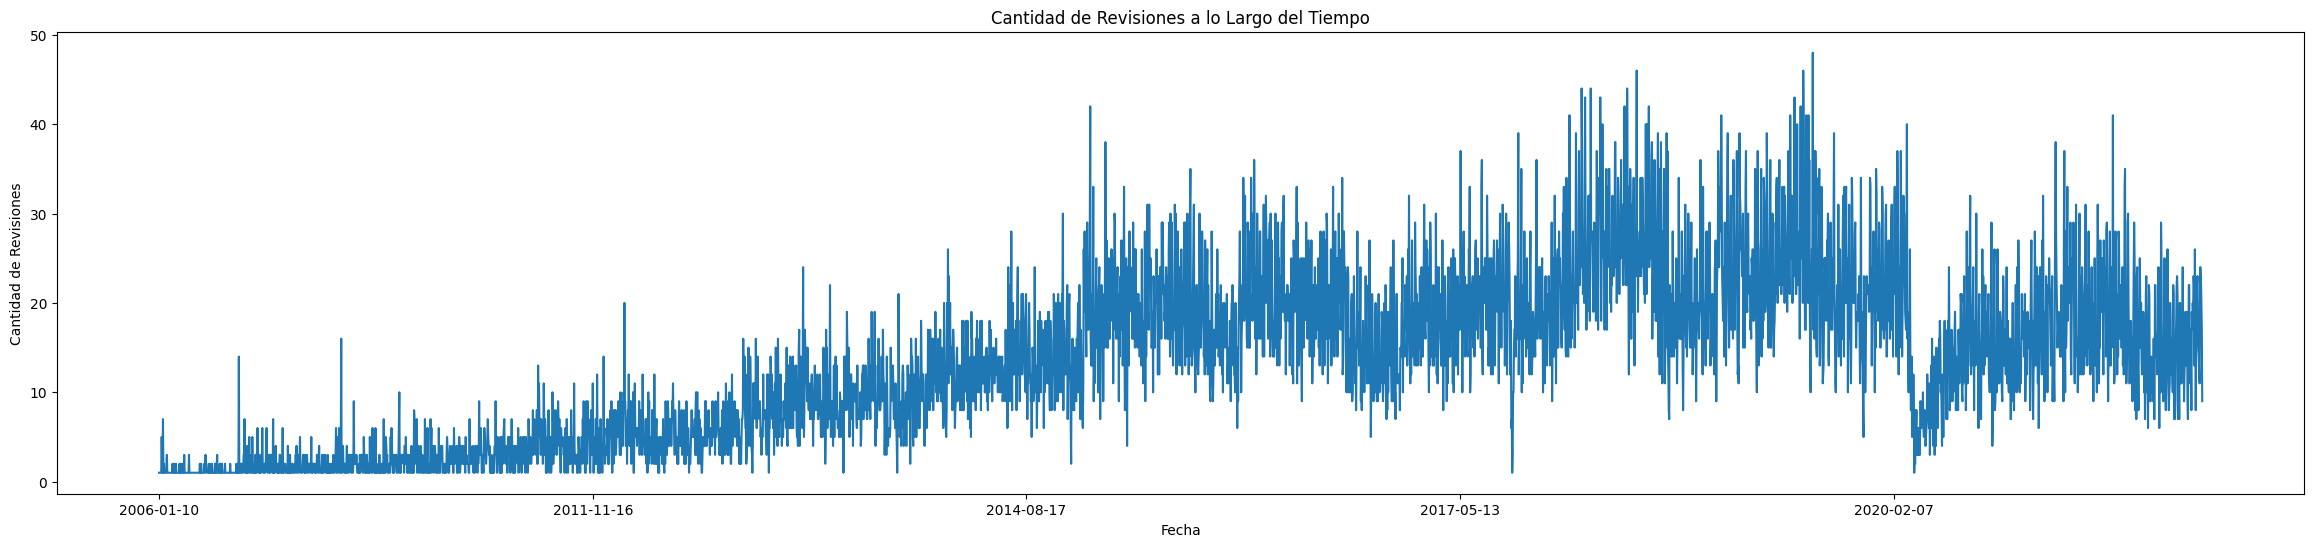

In [35]:
revisiones_por_fecha = df_desanidado['date'].value_counts().sort_index()

# Gráfico de líneas
plt.figure(figsize=(29, 6))
revisiones_por_fecha.plot()
plt.title('Cantidad de Revisiones a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Revisiones')
plt.show()

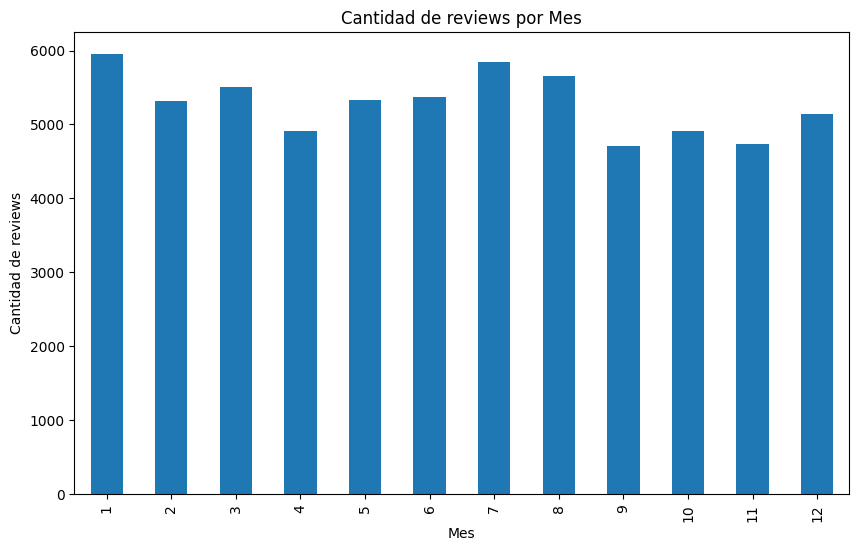

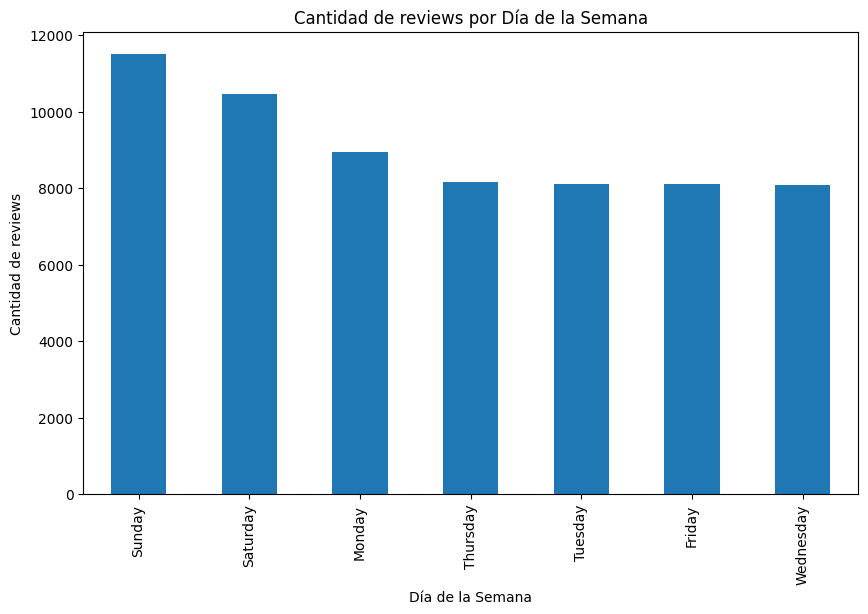

In [37]:

df_desanidado['date'] = pd.to_datetime(df_desanidado['date'], errors='coerce')


df_desanidado['mes'] = df_desanidado['date'].dt.month
df_desanidado['dia_semana'] = df_desanidado['date'].dt.day_name()

# Gráfico de barras para la cantidad de revisiones por mes
plt.figure(figsize=(10, 6))
df_desanidado['mes'].value_counts().sort_index().plot(kind='bar')
plt.title('Cantidad de reviews por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de reviews')
plt.show()

# Gráfico de barras para la cantidad de revisiones por día de la semana
plt.figure(figsize=(10, 6))
df_desanidado['dia_semana'].value_counts().plot(kind='bar')
plt.title('Cantidad de reviews por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de reviews')
plt.show()


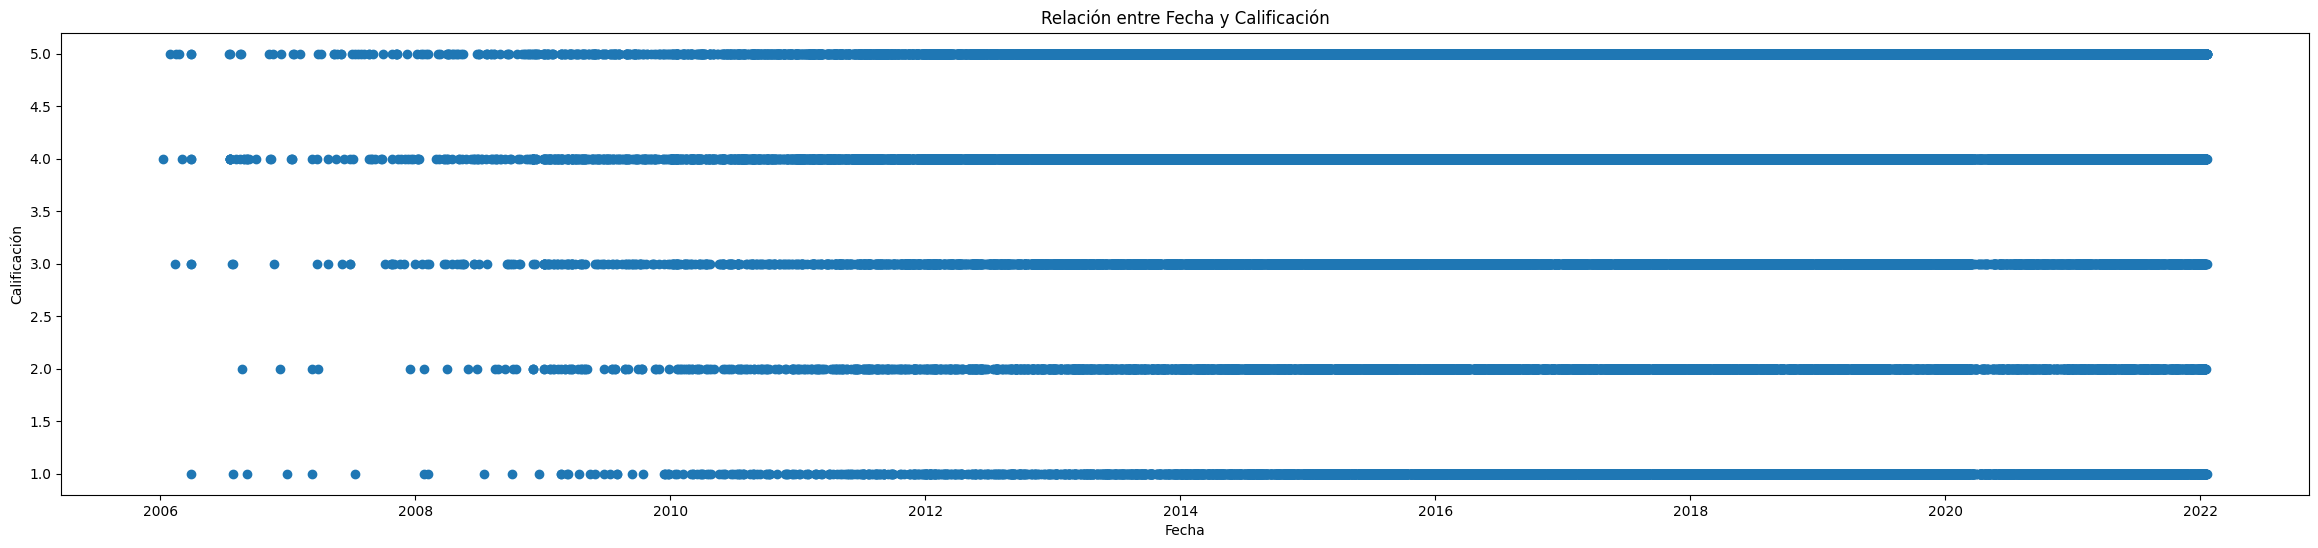

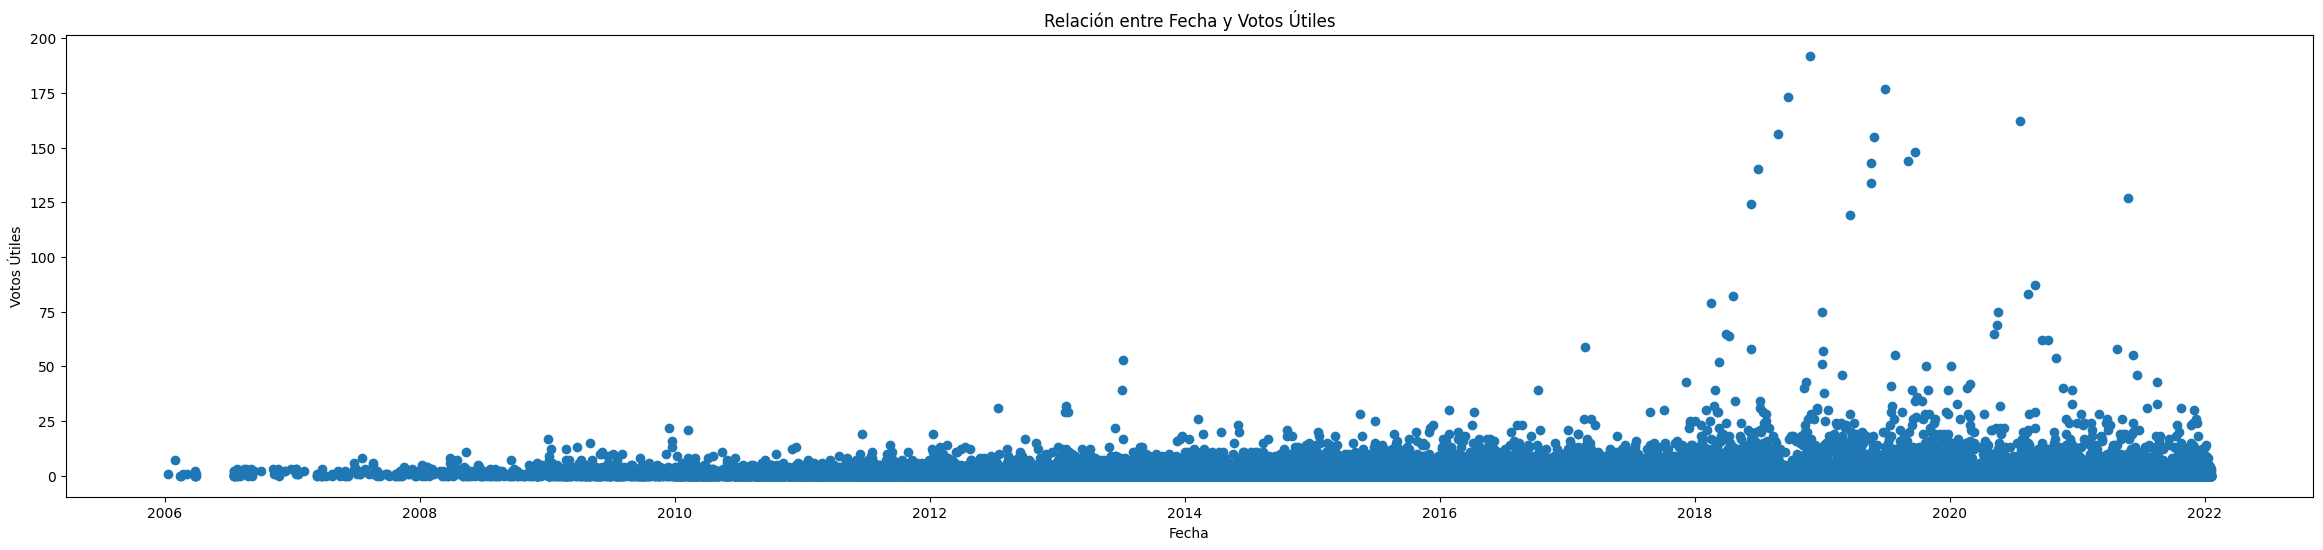

In [38]:
# Gráfico de dispersión para la relación entre fecha y calificación
plt.figure(figsize=(29, 6))
plt.scatter(df_desanidado['date'], df_desanidado['stars'])
plt.title('Relación entre Fecha y Calificación')
plt.xlabel('Fecha')
plt.ylabel('Calificación')
plt.show()

# Gráfico de dispersión para la relación entre fecha y votos útiles
plt.figure(figsize=(29, 6))
plt.scatter(df_desanidado['date'], df_desanidado['useful'])
plt.title('Relación entre Fecha y Votos Útiles')
plt.xlabel('Fecha')
plt.ylabel('Votos Útiles')
plt.show()


### ANALISIS DE CORRELACION

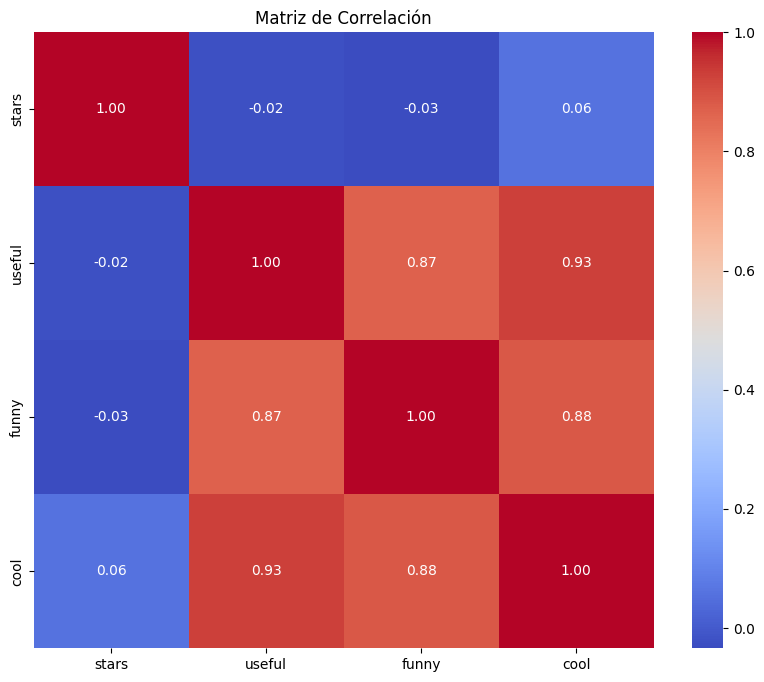

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo las columnas numéricas del DataFrame
df_numerico = df_desanidado.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlacion = df_numerico.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


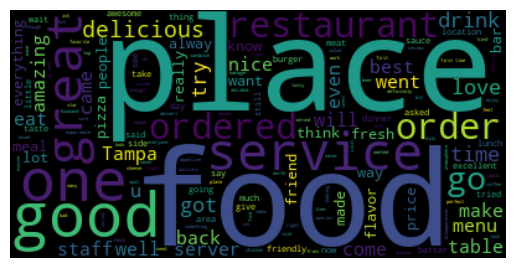

In [41]:
# Creamos la lista de palabras
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])

# Convertimos todos los valores en la columna 'review' a cadenas de texto
text = " ".join(str(text) for text in df_desanidado.text)

# Creamos la nube de palabras
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Mostramos la nube de palabras
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()